# Bitcoin price forecasting with PySpark
## Big Data Computing final project - A.Y. 2022 - 2023
Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author
Corsi Danilo - corsi.1742375@studenti.uniroma1.it



### Introduction

The cryptocurrency Bitcoin has attracted the attention of many people in recent years. However, it's
price fluctuation can be extremely unpredictable, which makes it difficult to predict when the right
time to buy or sell this digital currency will be. In this context, forecasting Bitcoin prices can be a
competitive advantage for investors and traders, as it could allow them to make informed decisions
on the right time to enter or exit the market. In this project, I will analyze some machine learning
techniques to understand, through the processing of historical data, how accurately the price of Bitcoin
can be predicted and whether this can provide added value to cryptocurrency investors and traders.
### Dataset
I chose to use the following dataset from Kaggle Bitcoin Historical Dataset, more specifically those
containing minute-by-minute updates of the Bitcoin price from 2017 to 2021 (period for which there
were moments of high volatility but also a lot of price lateralisation). The columns (features) contained
in it, in addition to the timestamp of each transaction, are the opening, closing, highest and lowest
price and the corresponding trading volume in Bitcoin and Dollars.
### Methods (TODO: da scegliere per bene)
The methods I will test will be Linear Regression (simple and multiple) and Random Forest. Further
comparisons with other classification models are planned in the course of development. Moreover, I
would also like to try to understand what the differences are between these methods and the imple-
mentation of a state-of-the-art neural network such as Long-Short Term Memory.
### Evaluation framework (TODO: vedi quali usare in base ai paper/esempi e ai modelli utilizzati)
As evaluation framework I will use R-square (R²), Mean Square Error (MSE) and Mean Absolute
Error (MAE) to get a complete picture of the performance of the various models.

# **Spark + Google Colab Setup**

## Global Constants


In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_DATASET_DIR = GDRIVE_DIR + "/MyDrive/Computer_Science/BDC/project/datasets"
GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/output.csv"

## Install PySpark and related dependencies





In [ ]:
!pip install pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1
!pip install -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=4668b3f4aa3d6c27ca3d53790303303f892d8cad62bc9156b4d24d7cac59bbf5
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

##  Import useful Python packages

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from itertools import cycle

import plotly.express as px

from pyspark.sql import functions as F

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import gc

##  Create Spark context

In [ ]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("BitcoinPriceForecasting").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

##  Link Colab to our Google Drive

In [ ]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


##  Check everything is ok

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.driver.port', '34501'),
 ('spark.app.startTime', '1685990412098'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'BitcoinPriceForecasting'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.b

#  LSTM ❗

In the first section, we use LSTM (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. Read more about LSTMs here.

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

In [ ]:
train_df.drop("features") \
  .drop("labelIndex") \
  .printSchema()

test_df.drop("features") \
  .drop("labelIndex") \
  .printSchema()

# USANDO KOALAS

# train_df_koalas = train_df.to_koalas()
# test_df_koalas = test_df.to_koalas()

# print("Training Dataset Count: " + str(train_df_koalas.shape[0]))
# print("Test Dataset Count: " + str(test_df_koalas.shape[0]))

# data_train = train_df_koalas
# data_test = test_df_koalas

# ------------------

# USANDO PANDAS

train_df_pandas = train_df.toPandas()
test_df_pandas = test_df.toPandas()

print("Training Dataset Count: " + str(train_df_pandas.shape[0]))
print("Test Dataset Count: " + str(test_df_pandas.shape[0]))

data_train = train_df_pandas
data_test = test_df_pandas

root
 |-- date: string (nullable = true)
 |-- close: double (nullable = true)

root
 |-- date: string (nullable = true)
 |-- close: double (nullable = true)



KeyboardInterrupt: ignored

In [ ]:
# data['date'] = data['date'].dt.tz_localize(None)
# data = data.groupby([pd.Grouper(key='date', freq='H')]).first().reset_index()
# data = data.set_index('date')
# data = data[['close']]
# data['close'].fillna(method='ffill', inplace=True)

In [ ]:
# # split data
# split_date = '20-Jul-2021'
# data_train = data.loc[data.index <= split_date].copy()
# data_test = data.loc[data.index > split_date].copy()

In [ ]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

KeyboardInterrupt: ignored

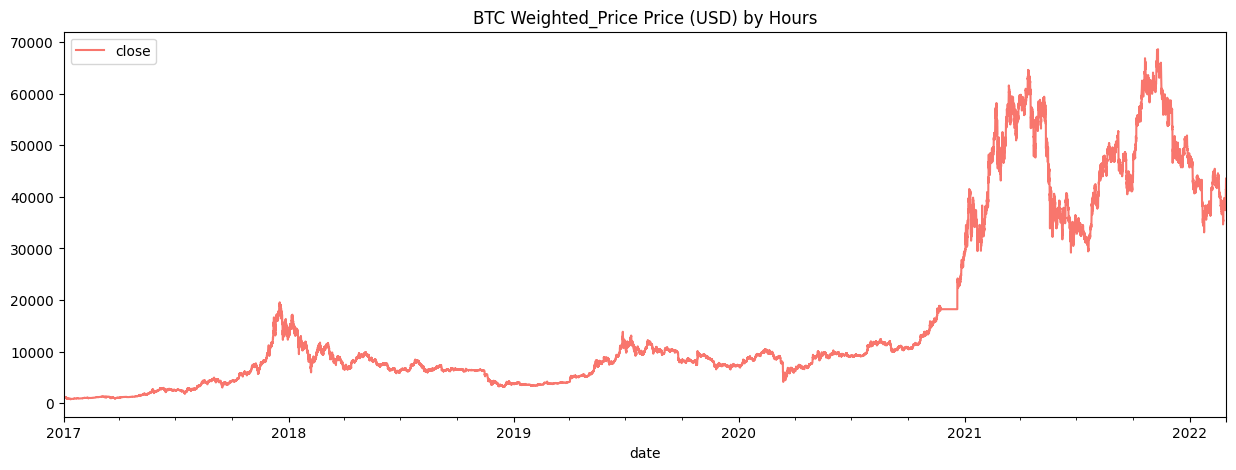

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

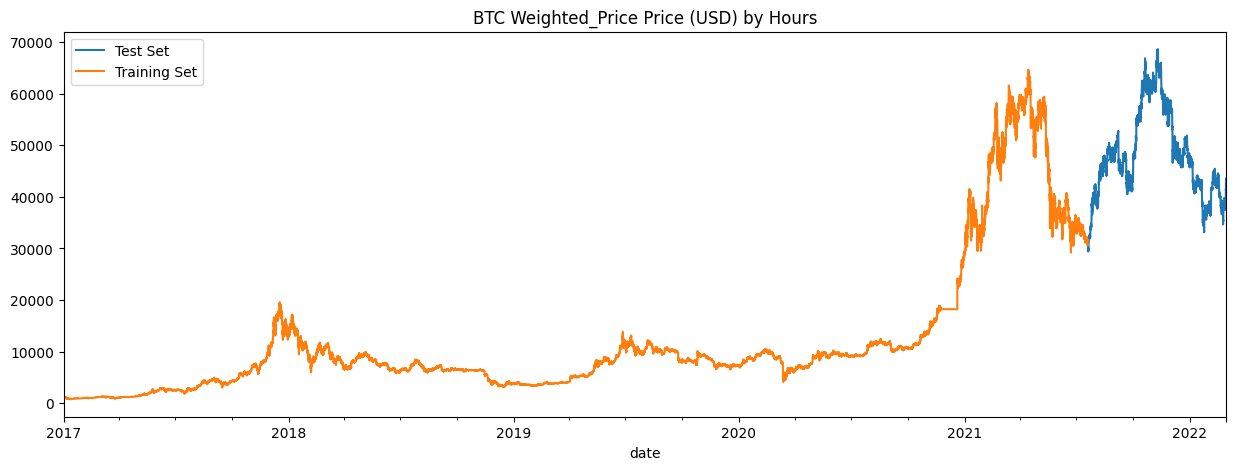

In [ ]:
_ = data_test \
    .rename(columns={'close': 'Test Set'}) \
    .join(data_train.rename(columns={'close': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

We will use a Vanilla LSTM here for forecasting. The model is trained on pre 25-Jun-2018 data.



In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
798/798 - 5s - loss: 0.0365 - 5s/epoch - 6ms/step
Epoch 2/100
798/798 - 4s - loss: 0.0102 - 4s/epoch - 5ms/step
Epoch 3/100
798/798 - 4s - loss: 0.0057 - 4s/epoch - 5ms/step
Epoch 4/100
798/798 - 3s - loss: 0.0040 - 3s/epoch - 4ms/step
Epoch 5/100
798/798 - 3s - loss: 0.0030 - 3s/epoch - 4ms/step
Epoch 6/100
798/798 - 3s - loss: 0.0024 - 3s/epoch - 4ms/step
Epoch 7/100
798/798 - 5s - loss: 0.0019 - 5s/epoch - 6ms/step
Epoch 8/100
798/798 - 3s - loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 9/100
798/798 - 3s - loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 10/100
798/798 - 3s - loss: 0.0012 - 3s/epoch - 4ms/step
Epoch 11/100
798/798 - 5s - loss: 0.0011 - 5s/epoch - 6ms/step
Epoch 12/100
798/798 - 3s - loss: 9.3623e-04 - 3s/epoch - 4ms/step
Epoch 13/100
798/798 - 3s - loss: 8.5249e-04 - 3s/epoch - 4ms/step
Epoch 14/100
798/798 - 3s - loss: 7.6311e-04 - 3s/epoch - 4ms/step
Epoch 15/100
798/798 - 4s - loss: 6.9920e-04 - 4s/epoch - 5ms/step
Epoch 16/100
798/798 - 4s - loss: 6.5857e-04 - 4

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

169/169 [==============================] - 1s 3ms/step


In [ ]:
data_test['close_prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

In [ ]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'close_prediction': 'lstm'})
final_data = final_data[['date','close','lstm']]

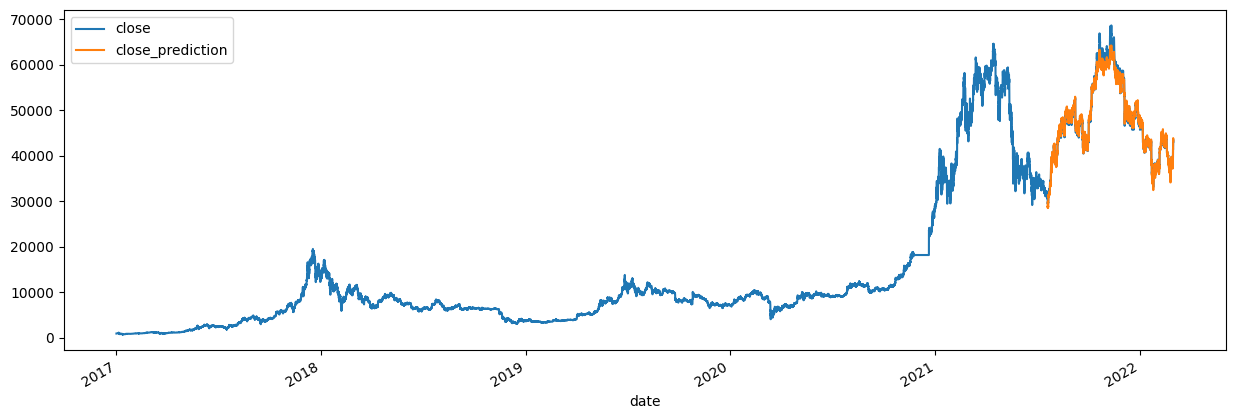

In [ ]:
_ = data_all[['close','close_prediction']].plot(figsize=(15, 5))

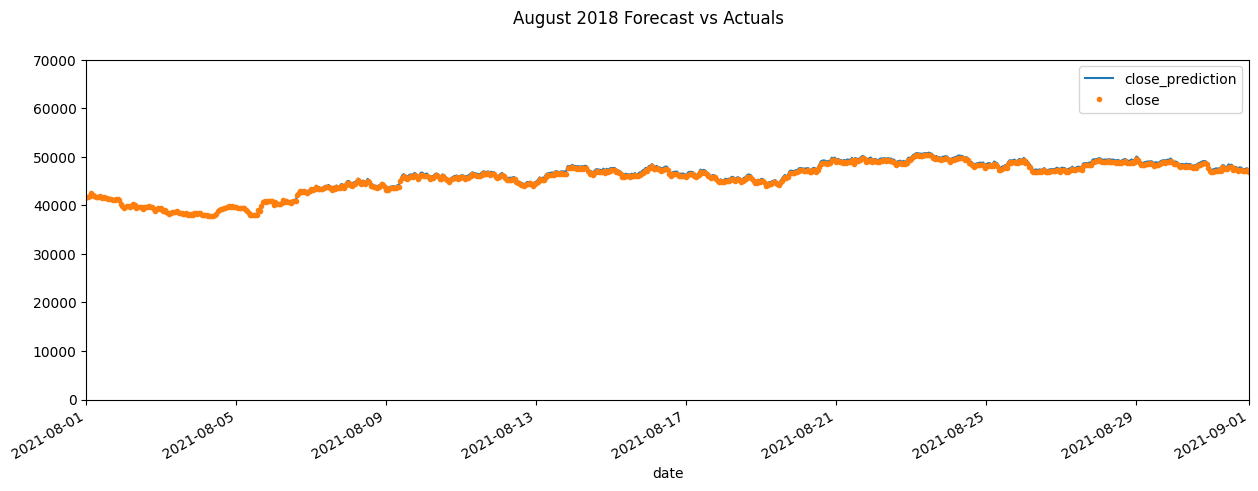

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='09-01-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

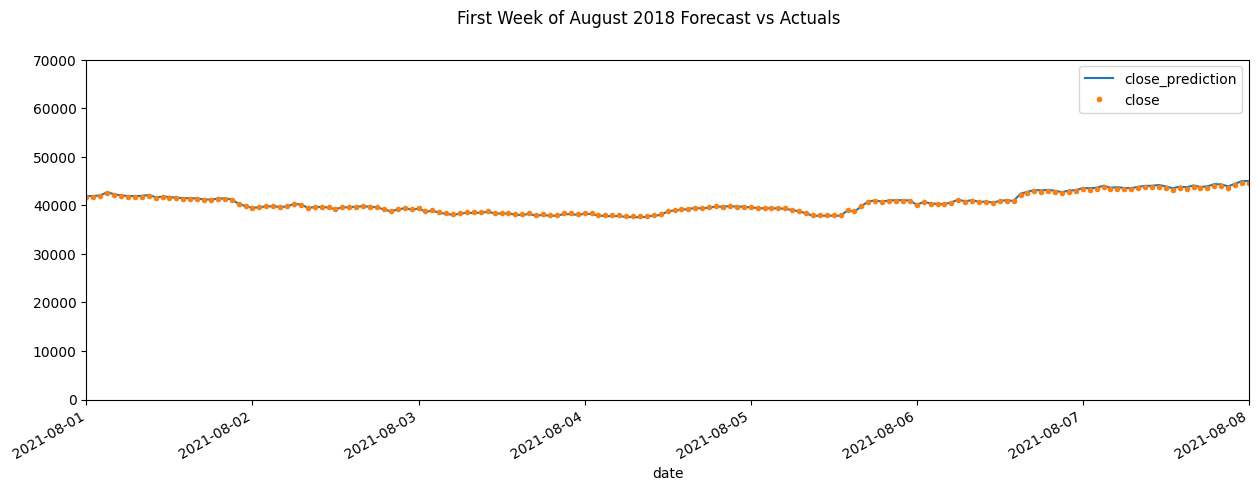

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='08-08-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

In [ ]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
= mean_squared_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

mae = mean_absolute_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

print("RMSE = %s" % (rmse)) # dovresti considerare il valore di RMSE in relazione al range dei valori target nel tuo problema specifico
print("R2 = %s" % (r2)) # piú é vicino ad 1 meglio é
print("MAE = %s" % (mae)) # può essere utile confrontare il valore di MAE con quello di altri modelli o con il range dei valori target per valutare la sua precisione
print("MAPE = %s" % (mape)) # di solito viene utilizzato come misura relativa per confrontare la precisione di modelli diversi
print("ADJ R2 = %s" % (adj_r2)) # piú é vicino ad 1 meglio é

769368.1511175948

577.1765881204685

We can clearly see the entire model is over-fitted.

